# ACL debugging with Batfish

This notebook contains examples to help answer some common questions about ACLs:
- What will a given ACL do with some packet? Which line in the ACL permits/denies the packet?
- Do any ACLs have lines that are unreachable by any packet?

In [ ]:
# Initialize a network and snapshot
%run startup.py

NETWORK_NAME = "acl_debugging_network"
SNAPSHOT_NAME = "example_snapshot"
SNAPSHOT_PATH = "../test_rigs/example"

bf_set_network(NETWORK_NAME)
try:
    bf_init_snapshot(SNAPSHOT_PATH, name=SNAPSHOT_NAME)
except:
    bf_set_snapshot(SNAPSHOT_NAME)

## The example network

Shown below is the example network used in this notebook.

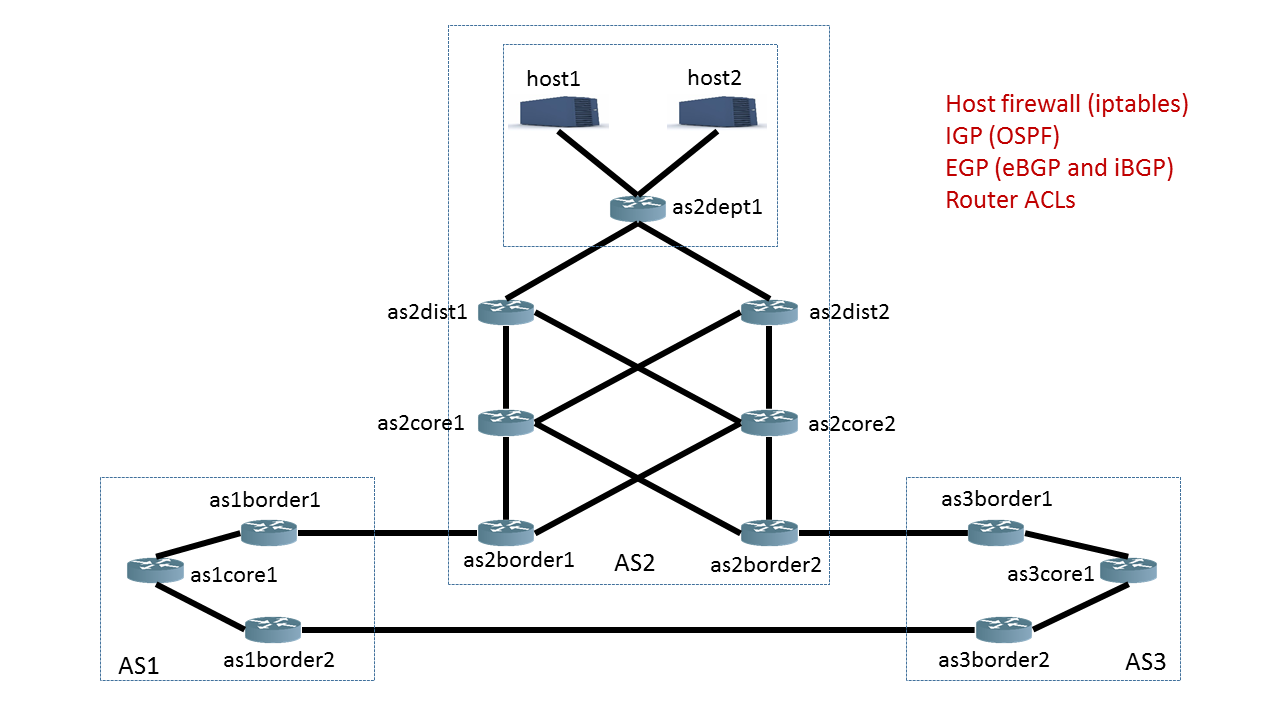

In [2]:
from IPython.display import Image
Image(filename = SNAPSHOT_PATH + "/example-network.png", width=960, height=540)

## Debugging flow for a given packet

The `tracefilters` question is helpful for spot-checking that particular packets are permitted or denied along a given path. For example, `host1` in our sample network is a DNS server, so ACLs should permit DNS packets destined for `host1`. Let's confirm that using `tracefilters`.

### Parameters of tracefilters
The non-optional paramters of `tracefilters` are `dst` (destination hostname or IP) and `srcIp`. When given only these two parameters, the result shows the behavior of every ACL in the network on a default packet.

The set of ACLs to examine can be narrowed down using two optional parameters:
- `nodeRegex` specifies the ACLs present on the set of nodes matching the given regex
- `filterRegex` specifies ACLs with names matching the given regex

There are also many optional parameters that specify the packet to examine. Check out the [documentation](https://pybatfish.readthedocs.io/en/latest/questions.html#pybatfish.question.bfq.tracefilters) for details.

#### Tip: Pull up a table of hostnames to IP addresses to help fill in `srcIp` and `dst`
`nodeProperties` achieves this nicely:

In [5]:
bfq.nodeProperties(nodeRegex=".*", propertySpec="canonical-ip").answer().frame()

,node,canonical-ip
0,as1border1,1.0.1.1
1,as1border2,1.0.2.1
2,as1core1,1.0.1.2
3,as2border1,2.1.1.1
4,as2border2,2.1.1.2
5,as2core1,2.1.2.1
6,as2core2,2.1.2.2
7,as2dept1,2.1.1.2
8,as2dist1,2.1.3.1
9,as2dist2,2.1.3.2


### Verifying that DNS requests will reach `host1`

Suppose `as1core1` sends a DNS request destined for DNS server `host1`. The packet will need to pass through `as1border1`, `as2border1`, `as2core1`, `as2dist1`, and `as2dept1`. It will hit the following ACLs:
- Entering `as2border1`: `OUTSIDE_TO_INSIDE`
- Entering `host1`: `filter::INPUT`

Running `tracefilters` for a DNS packet going from `as1core1` to `host1` shows that the packet is accepted by both ACLs, as expected. It also shows which line in each ACL accepts the packet.

In [6]:
host1_ip = "2.128.0.101"
as1core1_ip = "1.0.1.2"
nodes = "as2border1|host1"
acls = "OUTSIDE_TO_INSIDE|filter::INPUT"
bfq.tracefilters(dst=host1_ip, srcIp=as1core1_ip, nodeRegex=nodes, filterRegex=acls, dstProtocol="dns").answer().frame()

,node,filterName,flow,action,lineNumber,lineContent,trace
0,as2border1,OUTSIDE_TO_INSIDE,as2border1->[:1.0.1.2->0:2.128.0.101 proto: 53...,ACCEPT,2,permit ip any any,Flow permitted by 'extended ipv4 access-list' ...
1,host1,filter::INPUT,host1->[:1.0.1.2->0:2.128.0.101 proto: 53 dscp...,ACCEPT,0,-p udp --dport 53 -j ACCEPT,"Flow permitted by ACL named 'filter::INPUT', i..."


### Verifying that `host1` can be reached via SSH
We would also like for `host1` to be reachable from `as1core1` by SSH, which we can check with a similar `tracefilter` question:

In [10]:
bfq.tracefilters(dst=host1_ip, srcIp=as1core1_ip, nodeRegex=nodes, filterRegex=acls, dstProtocol="ssh").answer().frame()

,node,filterName,flow,action,lineNumber,lineContent,trace
0,as2border1,OUTSIDE_TO_INSIDE,as2border1->[:1.0.1.2->0:2.128.0.101 proto: 22...,ACCEPT,2,permit ip any any,Flow permitted by 'extended ipv4 access-list' ...
1,host1,filter::INPUT,host1->[:1.0.1.2->0:2.128.0.101 proto: 22 dscp...,ACCEPT,1,-p tcp --dport 22 -j ACCEPT,"Flow permitted by ACL named 'filter::INPUT', i..."


### Confirming that other packets will not reach `host1`

Outside of DNS and SSH, `host1` should not ultimately receive any traffic from `as1core1`. The next cell spot-checks some other packets with `tracefilters` to help confirm this. The only packets found to be accepted by both ACLs are TCP to port 22 (SSH) and UDP to port 53 (DNS).

In [22]:
common_ports = {
    'tcp': [1, 20, 22, 25, 80, 156, 179, 389, 443, 444],
    'udp': [7, 13, 37, 42, 49, 53, 107, 123, 156, 161]
}

for protocol in common_ports:
    for port in common_ports[protocol]:
        
        # Run tracefilters with the packet specified by protocol and port
        traceFiltersResult = bfq.tracefilters(dst=host1_ip, srcIp=as1core1_ip, nodeRegex=nodes, filterRegex=acls, dstProtocol=protocol, dstPort=port).answer().frame()
        
        # Create a filtered version of the result that only contains the ACLs that denied the packet
        rejectsOnly = traceFiltersResult[traceFiltersResult['action'].apply(lambda action:'REJECT'==action)]
        
        # If the filtered result is empty, then no ACLs denied the packet. Report that host1 accepted it.
        if len(rejectsOnly) == 0:
            print("Accepted: " + protocol + " on port " + str(port))

Accepted: tcp on port 22
Accepted: udp on port 53


## Ensuring all ACL lines are reachable

When debugging or editing ACLs, it can be useful to confirm that every line is reachable -- that is, it matches some set of packets that don't match earlier lines. Often unreachable ACL lines are symptomatic of past edits to the ACL that did not achieve their intent.

The `aclReachability` question identifies unreachable ACL lines. Given no parameters, it will check every ACL in the network, but the scope can be narrowed down using parameters `aclNameRegex` and `nodeRegex` (see [documentation](https://pybatfish.readthedocs.io/en/latest/questions.html#pybatfish.question.bfq.aclReachability)).

For now, let's take a look at all the ACLs in the network.

In [13]:
aclReachAnswer = bfq.aclReachability().answer().frame()
aclReachAnswer

,aclSources,lines,blockedLineNum,blockingLineNums,differentAction,message
0,[as2dept1: RESTRICT_HOST_TRAFFIC_IN],"[permit ip 2.128.0.0 0.0.255.255 any, deny i...",2,[1],True,ACLs { as2dept1: RESTRICT_HOST_TRAFFIC_IN } co...
1,[as2dept1: RESTRICT_HOST_TRAFFIC_OUT],"[permit ip any 2.128.0.0 0.0.255.255, deny i...",1,[0],True,ACLs { as2dept1: RESTRICT_HOST_TRAFFIC_OUT } c...


### Examining ACL reachability results
The answer identifies 2 unreachable lines. Let's take a closer look at the first one, line 2 in ACL `RESTRICT_HOST_TRAFFIC_IN` on node `as2dept1`. The `lines` column contains all the lines of the ACL, so the blocked and blocking lines can be found programmatically using their line numbers. The `message` column provides a human-readable result summary.

In [14]:
# Pull out first result
firstResult = aclReachAnswer.iloc[0]

# Find the blocked and blocking lines from the lines column
lines = firstResult['lines']
blocking_nums = firstResult['blockingLineNums']
blocked_num = firstResult['blockedLineNum']
blocking_lines = [lines[int(n)] for n in blocking_nums]
blocked_line = lines[blocked_num]
print('Results based on looking up lines in lines column:')
print('Blocked line: ' + blocked_line)
print('Blocking line(s): ' + str(blocking_lines))
print()

# Show the human-readable message
print("Message column:")
print(firstResult['message'])

Results based on looking up lines in lines column:
Blocked line: permit icmp any any
Blocking line(s): ['deny   ip any any']

Message column:
ACLs { as2dept1: RESTRICT_HOST_TRAFFIC_IN } contain an unreachable line:
  [index 2] permit icmp any any
Blocking line(s):
  [index 1] deny   ip any any


In this case, the line is unreachable because previous line `deny ip any any` matches and denies all packets that `permit icmp any any` would have permitted. The `aclReachability` question also identifies:
- inherently unmatchable lines
- unreachable lines blocked by multiple partially blocking lines
- lines that have an uncertain impact because they contain an undefined or circular reference